In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 
import time
from datetime import timedelta
import math
import pickle
import copy
import seaborn as sns
from numpy import sqrt 

plt.rcParams['axes.unicode_minus'] = False 

pd.options.display.float_format = '{:.5f}'.format

import warnings 
warnings.filterwarnings(action='ignore')
pd.options.display.float_format = '{:.5f}'.format

In [5]:
df = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/FactoryHack2022/Final/data/B기업_데이터 (비식별화).xlsx')
df_dropna = df.dropna(axis=0, subset=['No.'])

## Preprocessing

- Target Variable Preprocessing

In [ ]:
df_dropna.dropna(subset=['운전 누적 시간\n(On-Off 횟수)'], inplace=True)
df_dropna.reset_index(drop=True, inplace=True)
df_dropna

,No.,Test No.,Lamp Ver. No.,Chamber No.,Lamp No.,Lot No.,운전 시작일,운전 종료일,운전 누적 시간\n(On-Off 횟수),현재 상태,1-수소공급량,2-수소공급량,1-산소공급량,2-산소공급량,1-버너회전수,2-버너회전수,1-버너속도,2-버너속도,1-핀치횟수,2-핀치횟수,핀치두께-상,핀치두께-중,핀치두께-하,핀치두께2-상,핀치두께2-중,핀치두께2-하,전극간격,채널,VERSION,전압(1차),전류(1차),역률(1차),전력(1차),온도(1차),전압(2차),전류(2차),역률(2차),전력(2차),온도(2차),강도,...,전극간격.1,채널.1,VERSION.1,전압(1차).1,전류(1차).1,역률(1차).1,전력(1차).1,온도(1차).1,전압(2차).1,전류(2차).1,역률(2차).1,전력(2차).1,온도(2차).1,강도.1,불량코드,판정,측정시간,합불여부,등록자,등록일시,수정자,수정일시,Head No.,"1-1\n(Pinch No.1, U돌출)","1-2\n(Pinch No.1, U평탄)","2-1\n(Pinch No.2, U돌출)","2-2\n(Pinch No.2, U평탄)","1-1\n(Pinch No.1, 배꼽 위로)","1-2\n(Pinch No.1, 배꼽 아래)","2-1\n(Pinch No.2, 배꼽 위로)","2-2\n(Pinch No.2, 배꼽 아래)",Pinch No.1\n정면부 측정 편차,Pinch No.2\n정면부 측정 편차,Pinch No.1\n측면부 측정 편차,Pinch No.2\n측면부 측정 편차,Leak No.,리크 부위,Pinch No. 1\n(℃),중앙\n(℃),Pinch No. 2\n(℃)
0,230.00000,21.00000,21.00000,3.00000,1.00000,GV4KI7P051,18.10.10 15:00,18.11.22 09:00,858:34\n(429),Alive,93.03000,90.37200,78.41100,87.71400,25.25100,21.26400,53.16000,53.16000,3682.65900,3680.00100,4.65150,4.49202,4.55847,4.71795,4.55847,4.63821,444.23154,1.00000,V4,497.15232,48.33573,132.38169,31.11189,15.94800,640.79064,11.13702,132.86013,4.79769,111.63600,551.53500,...,444.23154,1.00000,V4,497.15232,48.33573,132.38169,31.11189,15.94800,640.79064,11.13702,132.86013,4.79769,111.63600,551.53500,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00000,0.00000,0.00000,0.00000,NaN,NaN,nan,nan,nan
1,231.00000,21.00000,21.00000,3.00000,2.00000,GV4KI7P052,18.10.10 15:00,18.11.22 09:00,858:34\n(429),Alive,93.03000,90.37200,78.41100,87.71400,25.25100,21.26400,53.16000,53.16000,3683.98800,3681.33000,4.66479,4.54518,4.58505,4.55847,4.47873,4.54518,443.76639,2.00000,V4,497.15232,48.33573,132.38169,31.11189,15.94800,659.03781,10.99083,132.80697,4.87743,111.63600,598.05000,...,443.76639,2.00000,V4,497.15232,48.33573,132.38169,31.11189,15.94800,659.03781,10.99083,132.80697,4.87743,111.63600,598.05000,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00000,0.00000,0.00000,0.00000,NaN,NaN,nan,nan,nan
2,232.00000,21.00000,21.00000,5.00000,1.00000,GV4KI7Q099,18.10.10 15:00,18.11.22 09:00,858:34\n(429),Alive,93.03000,90.37200,78.41100,87.71400,25.25100,21.26400,53.16000,53.16000,3863.40300,3860.74500,4.73124,4.62492,4.61163,4.55847,4.54518,4.49202,440.47047,1.00000,V4,507.70458,47.68452,132.32853,31.29795,15.94800,649.98732,11.20347,132.78039,4.89072,120.93900,571.47000,...,440.47047,1.00000,V4,507.70458,47.68452,132.32853,31.29795,15.94800,649.98732,11.20347,132.78039,4.89072,120.93900,571.47000,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00000,0.00000,0.00000,0.00000,NaN,NaN,nan,nan,nan
3,233.00000,21.00000,21.00000,5.00000,2.00000,GV4KI7Q100,18.10.10 15:00,18.11.22 09:00,858:34\n(429),Alive,93.03000,90.37200,78.41100,87.71400,25.25100,21.26400,53.16000,53.16000,3864.73200,3862.07400,4.74453,4.58505,4.61163,4.53189,4.54518,4.49202,444.00561,2.00000,V4,507.70458,47.68452,132.32853,31.29795,15.94800,654.95778,11.05728,132.68736,4.86414,120.93900,591.40500,...,444.00561,2.00000,V4,507.70458,47.68452,132.32853,31.29795,15.94800,654.95778,11.05728,132.68736,4.86414,120.93900,591.40500,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00000,0.00000,0.00000,0.00000,NaN,NaN,nan,nan,nan
4,234.00000,21.00000,21.00000,6.00000,1.00000,GV4KI8A058,18.10.10 15:00,18.11.22 09:00,838:17\n(419),Alive,93.03000,90.37200,78.41100,87.71400,25.25100,21.26400,53.16000,53.16000,252.51000,252.51000,4.71795,4.67808,4.65150,4.67808,4.73124,4.65150,443.15505,5.00000,V4,501.31209,47.65794,132.16905,30.83280,17.27700,642.29241,11.26992,132.78039,4.83756,108.97800,582.10200,...,443.15505,5.00000,V4,501.31209,47.65794,132.16905,30.83280,17.27700,642.29241,11.26992,132.78039,4.83756,108.97800,582.10200,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00000,0.00000,0.00000,0.00000,NaN,NaN,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
df_dropna['y_cum_time'] = df_dropna['운전 누적 시간\n(On-Off 횟수)'].apply(lambda x: x.split("\n")[0])
df_dropna['y_on_off'] = df_dropna['운전 누적 시간\n(On-Off 횟수)'].apply(lambda x: int(x.split("\n")[1][1:-1]))

In [ ]:
for i in range(len(df_dropna['y_cum_time'])):
    h = int(df_dropna.iloc[i, :]['y_cum_time'].split(":")[0])
    m = int(df_dropna.iloc[i, :]['y_cum_time'].split(":")[1])
    
    delta = timedelta(hours=h, minutes=m)
    total_seconds = delta.total_seconds()
    hours = round(total_seconds//60 / 60, 2)
    
    df_dropna.loc[i, 'y_cum_time'] = float(hours)
    
df_dropna['y_cum_time'] = df_dropna['y_cum_time'].apply(lambda x: float(x)) 

- 중복 컬럼 제외 

In [ ]:
df_drop_dups = df_dropna.T.drop_duplicates(keep='first').T
df_drop_dups.drop(['운전 시작일', '운전 종료일' ,'운전 누적 시간\n(On-Off 횟수)'], axis=1, inplace=True)
df_drop_dups.reset_index(drop=True,inplace=True)

In [ ]:
df_dropna.T.drop_duplicates(keep='first').T.columns

Index(['No.', 'Test No.', 'Lamp Ver. No.', 'Chamber No.', 'Lamp No.',
       'Lot No.', '운전 시작일', '운전 종료일', '운전 누적 시간\n(On-Off 횟수)', '현재 상태',
       '1-수소공급량', '2-수소공급량', '1-산소공급량', '2-산소공급량', '1-버너회전수', '2-버너회전수',
       '1-버너속도', '2-버너속도', '1-핀치횟수', '2-핀치횟수', '핀치두께-상', '핀치두께-중', '핀치두께-하',
       '핀치두께2-상', '핀치두께2-중', '핀치두께2-하', '전극간격', '채널', 'VERSION', '전압(1차)',
       '전류(1차)', '역률(1차)', '전력(1차)', '온도(1차)', '전압(2차)', '전류(2차)', '역률(2차)',
       '전력(2차)', '온도(2차)', '강도', '불량코드', '판정', '측정시간', '등록자', '등록일시', '수정자',
       '수정일시', '1-1\n(Pinch No.1, U돌출)', '1-2\n(Pinch No.1, U평탄)',
       '2-1\n(Pinch No.2, U돌출)', '2-2\n(Pinch No.2, U평탄)',
       '1-1\n(Pinch No.1, 배꼽 위로)', '1-2\n(Pinch No.1, 배꼽 아래)',
       '2-1\n(Pinch No.2, 배꼽 위로)', '2-2\n(Pinch No.2, 배꼽 아래)',
       'Pinch No.1\n정면부 측정 편차', 'Pinch No.2\n정면부 측정 편차',
       'Pinch No.1\n측면부 측정 편차', 'Pinch No.2\n측면부 측정 편차', 'Leak No.', '리크 부위',
       'Pinch No. 1\n(℃)', '중앙\n(℃)', 'Pinch No. 2\n(℃)', 'y_cum_time',
       'y_on_off'],


In [ ]:
df_dropna[df_dropna['전류(2차)'] == 0]

,No.,Test No.,Lamp Ver. No.,Chamber No.,Lamp No.,Lot No.,운전 시작일,운전 종료일,운전 누적 시간\n(On-Off 횟수),현재 상태,1-수소공급량,2-수소공급량,1-산소공급량,2-산소공급량,1-버너회전수,2-버너회전수,1-버너속도,2-버너속도,1-핀치횟수,2-핀치횟수,핀치두께-상,핀치두께-중,핀치두께-하,핀치두께2-상,핀치두께2-중,핀치두께2-하,전극간격,채널,VERSION,전압(1차),전류(1차),역률(1차),전력(1차),온도(1차),전압(2차),전류(2차),역률(2차),전력(2차),온도(2차),강도,...,VERSION.1,전압(1차).1,전류(1차).1,역률(1차).1,전력(1차).1,온도(1차).1,전압(2차).1,전류(2차).1,역률(2차).1,전력(2차).1,온도(2차).1,강도.1,불량코드,판정,측정시간,합불여부,등록자,등록일시,수정자,수정일시,Head No.,"1-1\n(Pinch No.1, U돌출)","1-2\n(Pinch No.1, U평탄)","2-1\n(Pinch No.2, U돌출)","2-2\n(Pinch No.2, U평탄)","1-1\n(Pinch No.1, 배꼽 위로)","1-2\n(Pinch No.1, 배꼽 아래)","2-1\n(Pinch No.2, 배꼽 위로)","2-2\n(Pinch No.2, 배꼽 아래)",Pinch No.1\n정면부 측정 편차,Pinch No.2\n정면부 측정 편차,Pinch No.1\n측면부 측정 편차,Pinch No.2\n측면부 측정 편차,Leak No.,리크 부위,Pinch No. 1\n(℃),중앙\n(℃),Pinch No. 2\n(℃),y_cum_time,y_on_off
69,334.00000,26.00000,36.00000,6.00000,2.00000,GV4KJ42044,19.05.07 14:35,19.05.17 10:20,202:05\n(101),Alive,104.99100,99.67500,97.01700,93.03000,22.59300,19.93500,53.16000,53.16000,4061.42400,4054.77900,4.50531,4.57176,4.53189,4.61163,4.63821,4.61163,445.29474,4.00000,V4,514.58880,18.06111,114.99837,10.37949,18.60600,820.63092,0,0,0,78.41100,6.64500,...,V4,514.58880,18.06111,114.99837,10.37949,18.60600,820.63092,0,0,0,78.41100,6.64500,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00000,0.00000,0.00000,0.00000,NaN,NaN,nan,nan,nan,202.08000,101


- datatype 변경

In [ ]:
uv_info = ['Test No.', 'Lamp Ver. No.', 'Chamber No.', 'Lot No.']

process = [ '1-수소공급량', '2-수소공급량', '1-산소공급량', '2-산소공급량', '1-버너회전수', '2-버너회전수',
       '1-버너속도', '2-버너속도', '1-핀치횟수', '2-핀치횟수', '핀치두께-상', '핀치두께-중', '핀치두께-하',
       '핀치두께2-상', '핀치두께2-중', '핀치두께2-하', '전극간격']

light_test = ['채널', '전압(1차)', '전류(1차)', '역률(1차)', '전력(1차)', '온도(1차)', '전압(2차)', '전류(2차)', '역률(2차)', '전력(2차)', '온도(2차)', '강도']

physics_test = ['1-1\n(Pinch No.1, U돌출)', '1-2\n(Pinch No.1, U평탄)', '2-1\n(Pinch No.2, U돌출)', '2-2\n(Pinch No.2, U평탄)',
       '1-1\n(Pinch No.1, 배꼽 위로)', '1-2\n(Pinch No.1, 배꼽 아래)', '2-1\n(Pinch No.2, 배꼽 위로)', '2-2\n(Pinch No.2, 배꼽 아래)',
        'Pinch No.1\n정면부 측정 편차', 'Pinch No.2\n정면부 측정 편차','Pinch No.1\n측면부 측정 편차', 'Pinch No.2\n측면부 측정 편차']

y= ['y_cum_time','현재 상태']

In [ ]:
data = df_drop_dups[uv_info+process+light_test+y]
data[light_test+process+['Test No.', 'Lamp Ver. No.', 'Chamber No.', 'y_cum_time']] = data[light_test+process+['Test No.', 'Lamp Ver. No.', 'Chamber No.','y_cum_time']].apply(pd.to_numeric, errors='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Test No.       304 non-null    float64
 1   Lamp Ver. No.  304 non-null    float64
 2   Chamber No.    304 non-null    float64
 3   Lot No.        304 non-null    object 
 4   1-수소공급량        304 non-null    float64
 5   2-수소공급량        304 non-null    float64
 6   1-산소공급량        304 non-null    float64
 7   2-산소공급량        304 non-null    float64
 8   1-버너회전수        304 non-null    float64
 9   2-버너회전수        304 non-null    float64
 10  1-버너속도         304 non-null    float64
 11  2-버너속도         304 non-null    float64
 12  1-핀치횟수         304 non-null    float64
 13  2-핀치횟수         304 non-null    float64
 14  핀치두께-상         304 non-null    float64
 15  핀치두께-중         304 non-null    float64
 16  핀치두께-하         304 non-null    float64
 17  핀치두께2-상        304 non-null    float64
 18  핀치두께2-중   

- 온도에 대한 결측치는 data imputation을 통해 채우기로 하고 나머지에 대한 결측치는 없애는 것으로 결정

In [ ]:
data_nan = pd.DataFrame(data.isnull().sum(), columns = ['count']).reset_index()
data_nan.rename(columns={'index':'parameter'})
data_nan[data_nan['count'] > 0]

,index,count
21,채널,1
22,전압(1차),1
23,전류(1차),1
24,역률(1차),1
25,전력(1차),1
26,온도(1차),9
27,전압(2차),3
28,전류(2차),1
29,역률(2차),3
30,전력(2차),3


In [ ]:
data_final = data.iloc[list(data[data['역률(2차)'].notnull()][light_test].index)].reset_index(drop=True)
data_final

,Test No.,Lamp Ver. No.,Chamber No.,Lot No.,1-수소공급량,2-수소공급량,1-산소공급량,2-산소공급량,1-버너회전수,2-버너회전수,1-버너속도,2-버너속도,1-핀치횟수,2-핀치횟수,핀치두께-상,핀치두께-중,핀치두께-하,핀치두께2-상,핀치두께2-중,핀치두께2-하,전극간격,채널,전압(1차),전류(1차),역률(1차),전력(1차),온도(1차),전압(2차),전류(2차),역률(2차),전력(2차),온도(2차),강도,y_cum_time,현재 상태
0,21.00000,21.00000,3.00000,GV4KI7P051,93.03000,90.37200,78.41100,87.71400,25.25100,21.26400,53.16000,53.16000,3682.65900,3680.00100,4.65150,4.49202,4.55847,4.71795,4.55847,4.63821,444.23154,1.00000,497.15232,48.33573,132.38169,31.11189,15.94800,640.79064,11.13702,132.86013,4.79769,111.63600,551.53500,858.57000,Alive
1,21.00000,21.00000,3.00000,GV4KI7P052,93.03000,90.37200,78.41100,87.71400,25.25100,21.26400,53.16000,53.16000,3683.98800,3681.33000,4.66479,4.54518,4.58505,4.55847,4.47873,4.54518,443.76639,2.00000,497.15232,48.33573,132.38169,31.11189,15.94800,659.03781,10.99083,132.80697,4.87743,111.63600,598.05000,858.57000,Alive
2,21.00000,21.00000,5.00000,GV4KI7Q099,93.03000,90.37200,78.41100,87.71400,25.25100,21.26400,53.16000,53.16000,3863.40300,3860.74500,4.73124,4.62492,4.61163,4.55847,4.54518,4.49202,440.47047,1.00000,507.70458,47.68452,132.32853,31.29795,15.94800,649.98732,11.20347,132.78039,4.89072,120.93900,571.47000,858.57000,Alive
3,21.00000,21.00000,5.00000,GV4KI7Q100,93.03000,90.37200,78.41100,87.71400,25.25100,21.26400,53.16000,53.16000,3864.73200,3862.07400,4.74453,4.58505,4.61163,4.53189,4.54518,4.49202,444.00561,2.00000,507.70458,47.68452,132.32853,31.29795,15.94800,654.95778,11.05728,132.68736,4.86414,120.93900,591.40500,858.57000,Alive
4,21.00000,21.00000,6.00000,GV4KI8A058,93.03000,90.37200,78.41100,87.71400,25.25100,21.26400,53.16000,53.16000,252.51000,252.51000,4.71795,4.67808,4.65150,4.67808,4.73124,4.65150,443.15505,5.00000,501.31209,47.65794,132.16905,30.83280,17.27700,642.29241,11.26992,132.78039,4.83756,108.97800,582.10200,838.28000,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,51.00000,69.00000,2.00000,GN4KL3V156,91.70100,87.71400,51.83100,63.79200,15.94800,15.94800,42.52800,47.84400,4442.84700,4444.17600,4.67808,2.33904,4.67808,4.33254,2.33904,4.39899,442.39752,5.00000,513.89772,46.31565,131.94312,30.63345,31.89600,633.89313,11.34966,132.56775,4.79769,33.22500,334.90800,946.02000,Gas leak
297,51.00000,69.00000,3.00000,GN4KL3V157,91.70100,87.71400,51.83100,63.79200,15.94800,15.94800,42.52800,47.84400,4444.17600,4445.50500,4.65150,2.23272,4.63821,4.30596,2.16627,4.37241,441.77289,6.00000,513.89772,46.31565,131.94312,30.63345,31.89600,640.47168,11.37624,132.59433,4.85085,33.22500,362.81700,520.35000,Gas leak
298,51.00000,69.00000,3.00000,GN4KL3V153,91.70100,87.71400,51.83100,63.79200,15.94800,15.94800,42.52800,47.84400,4438.86000,4440.18900,4.66479,2.57826,4.66479,4.34583,2.24601,4.42557,442.46397,2.00000,513.89772,46.31565,131.94312,30.63345,31.89600,641.41527,11.12373,132.35511,4.77111,33.22500,333.57900,234.13000,Gas leak
299,51.00000,69.00000,4.00000,GN4KL3V144,91.70100,87.71400,51.83100,63.79200,15.94800,15.94800,42.52800,47.84400,4426.89900,4428.22800,4.73124,2.51181,4.71795,4.30596,2.31246,4.37241,442.90254,2.00000,519.67887,46.30236,131.99628,30.99228,33.22500,644.64474,11.20347,132.28866,4.82427,33.22500,341.55300,448.12000,Gas leak


- 온도에 대한 결측치만 남음

In [ ]:
data_nan_f = pd.DataFrame(data_final.isnull().sum(), columns = ['count']).reset_index()
data_nan_f.rename(columns={'index':'parameter'})
data_nan_f[data_nan_f['count'] > 0]

,index,count
26,온도(1차),8
31,온도(2차),8


In [ ]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Test No.       301 non-null    float64
 1   Lamp Ver. No.  301 non-null    float64
 2   Chamber No.    301 non-null    float64
 3   Lot No.        301 non-null    object 
 4   1-수소공급량        301 non-null    float64
 5   2-수소공급량        301 non-null    float64
 6   1-산소공급량        301 non-null    float64
 7   2-산소공급량        301 non-null    float64
 8   1-버너회전수        301 non-null    float64
 9   2-버너회전수        301 non-null    float64
 10  1-버너속도         301 non-null    float64
 11  2-버너속도         301 non-null    float64
 12  1-핀치횟수         301 non-null    float64
 13  2-핀치횟수         301 non-null    float64
 14  핀치두께-상         301 non-null    float64
 15  핀치두께-중         301 non-null    float64
 16  핀치두께-하         301 non-null    float64
 17  핀치두께2-상        301 non-null    float64
 18  핀치두께2-중   

## Imputation

- 0 값 가지고 있는 열 확인

In [ ]:
data_final.eq(0).sum()

Test No.          0
Lamp Ver. No.     0
Chamber No.       0
Lot No.           0
1-수소공급량           0
2-수소공급량           0
1-산소공급량           0
2-산소공급량           0
1-버너회전수           0
2-버너회전수           0
1-버너속도            0
2-버너속도            0
1-핀치횟수            0
2-핀치횟수            0
핀치두께-상            0
핀치두께-중            0
핀치두께-하            0
핀치두께2-상           0
핀치두께2-중           0
핀치두께2-하           0
전극간격              0
채널                0
전압(1차)            0
전류(1차)            0
역률(1차)            0
전력(1차)            0
온도(1차)            0
전압(2차)           71
전류(2차)            1
역률(2차)           72
전력(2차)           72
온도(2차)            0
강도                0
y_cum_time        0
현재 상태             0
dtype: int64

In [ ]:
len(df[df.eq(0).any(1)])

300

### 결측치 : 0 값 문제
아래의  분포 그림을 확인하면 0은 확실한 이상치임을 알 수 있다.  
값이 기록이 되지 않은거인지, 측정을 했는데 전류, 전압이 실제로 0인건지는 모르겠음  (결과와 연관성이 있는 0 인지 모르겠다)


전압(2차), 역률(2차), 전력(2차) 의 경우 0값을 가지는 72개의 행이 정확히 일치함   

일단은 0값을 결측치라 가정하고 진행  

0 --> null 

In [ ]:
nozero_df = data_final.replace(0, np.NaN)
nozero_df[nozero_df.isnull().any(axis = 1)]

,Test No.,Lamp Ver. No.,Chamber No.,Lot No.,1-수소공급량,2-수소공급량,1-산소공급량,2-산소공급량,1-버너회전수,2-버너회전수,1-버너속도,2-버너속도,1-핀치횟수,2-핀치횟수,핀치두께-상,핀치두께-중,핀치두께-하,핀치두께2-상,핀치두께2-중,핀치두께2-하,전극간격,채널,전압(1차),전류(1차),역률(1차),전력(1차),온도(1차),전압(2차),전류(2차),역률(2차),전력(2차),온도(2차),강도,y_cum_time,현재 상태
69,26.00000,36.00000,6.00000,GV4KJ42044,104.99100,99.67500,97.01700,93.03000,22.59300,19.93500,53.16000,53.16000,4061.42400,4054.77900,4.50531,4.57176,4.53189,4.61163,4.63821,4.61163,445.29474,4.00000,514.58880,18.06111,114.99837,10.37949,18.60600,820.63092,nan,nan,nan,78.41100,6.64500,202.08000,Alive
99,29.00000,41.00000,9.00000,GV4KJ8D064,99.67500,101.00400,91.70100,94.35900,21.26400,22.59300,53.16000,53.16000,591.40500,590.07600,4.45215,4.45215,4.37241,4.57176,4.57176,4.50531,443.60691,1.00000,514.40274,47.03331,132.27537,31.29795,37.21200,nan,11.13702,nan,nan,34.55400,479.76900,754.35000,Alive
100,29.00000,41.00000,9.00000,GV4KJ8D070,99.67500,101.00400,91.70100,94.35900,21.26400,22.59300,53.16000,53.16000,599.37900,598.05000,4.39899,4.43886,4.34583,4.57176,4.55847,4.53189,445.99911,5.00000,514.40274,47.03331,132.27537,31.29795,37.21200,nan,11.12373,nan,nan,34.55400,523.62600,327.20000,Gas leak
101,29.00000,41.00000,9.00000,GV4KJ8D085,99.67500,101.00400,91.70100,94.35900,21.26400,22.59300,53.16000,53.16000,619.31400,617.98500,4.29267,4.33254,4.23951,4.49202,4.43886,4.45215,445.60041,2.00000,518.32329,47.11305,132.24879,31.49730,38.54100,nan,11.04399,nan,nan,35.88300,449.20200,427.15000,Alive
102,29.00000,41.00000,10.00000,GV4KJ8D075,99.67500,101.00400,91.70100,94.35900,21.26400,22.59300,53.16000,53.16000,606.02400,604.69500,4.35912,4.38570,4.27938,4.54518,4.57176,4.50531,445.18842,6.00000,514.40274,47.03331,132.27537,31.29795,37.21200,nan,11.16360,nan,nan,34.55400,520.96800,784.92000,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,45.00000,61.00000,2.00000,GN4KK9G022,97.01700,91.70100,53.16000,70.43700,15.94800,15.94800,42.52800,47.84400,205.99500,205.99500,4.55847,4.53189,4.51860,4.50531,4.75782,4.49202,443.08860,6.00000,512.23647,47.64465,132.31524,31.55046,nan,658.25370,11.29650,132.82026,4.99704,nan,392.05500,886.05000,Gas leak
272,45.00000,62.00000,3.00000,GN4KK9G029,97.01700,91.70100,53.16000,70.43700,15.94800,15.94800,42.52800,47.84400,215.29800,215.29800,4.55847,4.51860,4.50531,4.57176,4.71795,4.53189,443.40756,1.00000,512.31621,47.21937,132.15576,31.21821,nan,642.86388,11.32308,132.63420,4.87743,nan,349.52700,595.95000,Gas leak
273,45.00000,62.00000,3.00000,GN4KK9G030,97.01700,91.70100,53.16000,70.43700,15.94800,15.94800,42.52800,47.84400,216.62700,216.62700,4.55847,4.53189,4.51860,4.63821,4.78440,4.61163,443.43414,2.00000,512.31621,47.21937,132.15576,31.21821,nan,652.20675,11.16360,132.52788,4.87743,nan,365.47500,1026.13000,Alive
274,45.00000,62.00000,4.00000,GN4KK9G031,97.01700,91.70100,53.16000,70.43700,15.94800,15.94800,42.52800,47.84400,217.95600,217.95600,4.49202,4.49202,4.43886,4.57176,4.77111,4.53189,443.16834,3.00000,512.31621,47.21937,132.15576,31.21821,nan,653.77497,11.28321,132.36840,4.91730,nan,358.83000,150.08000,Gas leak


### multivariate feature imputation   
https://scikit-learn.org/stable/modules/impute.html

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
df_for_impute = nozero_df.drop(columns=['Lot No.','y_cum_time', '현재 상태'])


imp = IterativeImputer(max_iter = 10, random_state = 0)
df_imputed = imp.fit_transform(df_for_impute)

df_imputed = pd.DataFrame(df_imputed, columns = df_for_impute.columns)
df_imputed

,Test No.,Lamp Ver. No.,Chamber No.,1-수소공급량,2-수소공급량,1-산소공급량,2-산소공급량,1-버너회전수,2-버너회전수,1-버너속도,2-버너속도,1-핀치횟수,2-핀치횟수,핀치두께-상,핀치두께-중,핀치두께-하,핀치두께2-상,핀치두께2-중,핀치두께2-하,전극간격,채널,전압(1차),전류(1차),역률(1차),전력(1차),온도(1차),전압(2차),전류(2차),역률(2차),전력(2차),온도(2차),강도
0,21.00000,21.00000,3.00000,93.03000,90.37200,78.41100,87.71400,25.25100,21.26400,53.16000,53.16000,3682.65900,3680.00100,4.65150,4.49202,4.55847,4.71795,4.55847,4.63821,444.23154,1.00000,497.15232,48.33573,132.38169,31.11189,15.94800,640.79064,11.13702,132.86013,4.79769,111.63600,551.53500
1,21.00000,21.00000,3.00000,93.03000,90.37200,78.41100,87.71400,25.25100,21.26400,53.16000,53.16000,3683.98800,3681.33000,4.66479,4.54518,4.58505,4.55847,4.47873,4.54518,443.76639,2.00000,497.15232,48.33573,132.38169,31.11189,15.94800,659.03781,10.99083,132.80697,4.87743,111.63600,598.05000
2,21.00000,21.00000,5.00000,93.03000,90.37200,78.41100,87.71400,25.25100,21.26400,53.16000,53.16000,3863.40300,3860.74500,4.73124,4.62492,4.61163,4.55847,4.54518,4.49202,440.47047,1.00000,507.70458,47.68452,132.32853,31.29795,15.94800,649.98732,11.20347,132.78039,4.89072,120.93900,571.47000
3,21.00000,21.00000,5.00000,93.03000,90.37200,78.41100,87.71400,25.25100,21.26400,53.16000,53.16000,3864.73200,3862.07400,4.74453,4.58505,4.61163,4.53189,4.54518,4.49202,444.00561,2.00000,507.70458,47.68452,132.32853,31.29795,15.94800,654.95778,11.05728,132.68736,4.86414,120.93900,591.40500
4,21.00000,21.00000,6.00000,93.03000,90.37200,78.41100,87.71400,25.25100,21.26400,53.16000,53.16000,252.51000,252.51000,4.71795,4.67808,4.65150,4.67808,4.73124,4.65150,443.15505,5.00000,501.31209,47.65794,132.16905,30.83280,17.27700,642.29241,11.26992,132.78039,4.83756,108.97800,582.10200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,51.00000,69.00000,2.00000,91.70100,87.71400,51.83100,63.79200,15.94800,15.94800,42.52800,47.84400,4442.84700,4444.17600,4.67808,2.33904,4.67808,4.33254,2.33904,4.39899,442.39752,5.00000,513.89772,46.31565,131.94312,30.63345,31.89600,633.89313,11.34966,132.56775,4.79769,33.22500,334.90800
297,51.00000,69.00000,3.00000,91.70100,87.71400,51.83100,63.79200,15.94800,15.94800,42.52800,47.84400,4444.17600,4445.50500,4.65150,2.23272,4.63821,4.30596,2.16627,4.37241,441.77289,6.00000,513.89772,46.31565,131.94312,30.63345,31.89600,640.47168,11.37624,132.59433,4.85085,33.22500,362.81700
298,51.00000,69.00000,3.00000,91.70100,87.71400,51.83100,63.79200,15.94800,15.94800,42.52800,47.84400,4438.86000,4440.18900,4.66479,2.57826,4.66479,4.34583,2.24601,4.42557,442.46397,2.00000,513.89772,46.31565,131.94312,30.63345,31.89600,641.41527,11.12373,132.35511,4.77111,33.22500,333.57900
299,51.00000,69.00000,4.00000,91.70100,87.71400,51.83100,63.79200,15.94800,15.94800,42.52800,47.84400,4426.89900,4428.22800,4.73124,2.51181,4.71795,4.30596,2.31246,4.37241,442.90254,2.00000,519.67887,46.30236,131.99628,30.99228,33.22500,644.64474,11.20347,132.28866,4.82427,33.22500,341.55300


In [ ]:
df_imputed = pd.concat([df_imputed, nozero_df[['Lot No.','y_cum_time', '현재 상태']]], axis = 1)

In [ ]:
df_imputed[nozero_df.isnull().any(axis = 1)]

,Test No.,Lamp Ver. No.,Chamber No.,1-수소공급량,2-수소공급량,1-산소공급량,2-산소공급량,1-버너회전수,2-버너회전수,1-버너속도,2-버너속도,1-핀치횟수,2-핀치횟수,핀치두께-상,핀치두께-중,핀치두께-하,핀치두께2-상,핀치두께2-중,핀치두께2-하,전극간격,채널,전압(1차),전류(1차),역률(1차),전력(1차),온도(1차),전압(2차),전류(2차),역률(2차),전력(2차),온도(2차),강도,Lot No.,y_cum_time,현재 상태
69,26.00000,36.00000,6.00000,104.99100,99.67500,97.01700,93.03000,22.59300,19.93500,53.16000,53.16000,4061.42400,4054.77900,4.50531,4.57176,4.53189,4.61163,4.63821,4.61163,445.29474,4.00000,514.58880,18.06111,114.99837,10.37949,18.60600,820.63092,9.33828,134.17555,211.02477,78.41100,6.64500,GV4KJ42044,202.08000,Alive
99,29.00000,41.00000,9.00000,99.67500,101.00400,91.70100,94.35900,21.26400,22.59300,53.16000,53.16000,591.40500,590.07600,4.45215,4.45215,4.37241,4.57176,4.57176,4.50531,443.60691,1.00000,514.40274,47.03331,132.27537,31.29795,37.21200,656.00634,11.13702,132.55459,266.18550,34.55400,479.76900,GV4KJ8D064,754.35000,Alive
100,29.00000,41.00000,9.00000,99.67500,101.00400,91.70100,94.35900,21.26400,22.59300,53.16000,53.16000,599.37900,598.05000,4.39899,4.43886,4.34583,4.57176,4.55847,4.53189,445.99911,5.00000,514.40274,47.03331,132.27537,31.29795,37.21200,664.77233,11.12373,132.74058,320.04761,34.55400,523.62600,GV4KJ8D070,327.20000,Gas leak
101,29.00000,41.00000,9.00000,99.67500,101.00400,91.70100,94.35900,21.26400,22.59300,53.16000,53.16000,619.31400,617.98500,4.29267,4.33254,4.23951,4.49202,4.43886,4.45215,445.60041,2.00000,518.32329,47.11305,132.24879,31.49730,38.54100,664.29226,11.04399,132.53526,273.90800,35.88300,449.20200,GV4KJ8D085,427.15000,Alive
102,29.00000,41.00000,10.00000,99.67500,101.00400,91.70100,94.35900,21.26400,22.59300,53.16000,53.16000,606.02400,604.69500,4.35912,4.38570,4.27938,4.54518,4.57176,4.50531,445.18842,6.00000,514.40274,47.03331,132.27537,31.29795,37.21200,662.93197,11.16360,132.72004,325.17092,34.55400,520.96800,GV4KJ8D075,784.92000,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,45.00000,61.00000,2.00000,97.01700,91.70100,53.16000,70.43700,15.94800,15.94800,42.52800,47.84400,205.99500,205.99500,4.55847,4.53189,4.51860,4.50531,4.75782,4.49202,443.08860,6.00000,512.23647,47.64465,132.31524,31.55046,33.23426,658.25370,11.29650,132.82026,4.99704,20.16285,392.05500,GN4KK9G022,886.05000,Gas leak
272,45.00000,62.00000,3.00000,97.01700,91.70100,53.16000,70.43700,15.94800,15.94800,42.52800,47.84400,215.29800,215.29800,4.55847,4.51860,4.50531,4.57176,4.71795,4.53189,443.40756,1.00000,512.31621,47.21937,132.15576,31.21821,33.38014,642.86388,11.32308,132.63420,4.87743,23.24823,349.52700,GN4KK9G029,595.95000,Gas leak
273,45.00000,62.00000,3.00000,97.01700,91.70100,53.16000,70.43700,15.94800,15.94800,42.52800,47.84400,216.62700,216.62700,4.55847,4.53189,4.51860,4.63821,4.78440,4.61163,443.43414,2.00000,512.31621,47.21937,132.15576,31.21821,33.88214,652.20675,11.16360,132.52788,4.87743,20.90149,365.47500,GN4KK9G030,1026.13000,Alive
274,45.00000,62.00000,4.00000,97.01700,91.70100,53.16000,70.43700,15.94800,15.94800,42.52800,47.84400,217.95600,217.95600,4.49202,4.49202,4.43886,4.57176,4.77111,4.53189,443.16834,3.00000,512.31621,47.21937,132.15576,31.21821,34.04910,653.77497,11.28321,132.36840,4.91730,18.65014,358.83000,GN4KK9G031,150.08000,Gas leak


In [ ]:
df_imputed.isnull().any()

Test No.         False
Lamp Ver. No.    False
Chamber No.      False
1-수소공급량          False
2-수소공급량          False
1-산소공급량          False
2-산소공급량          False
1-버너회전수          False
2-버너회전수          False
1-버너속도           False
2-버너속도           False
1-핀치횟수           False
2-핀치횟수           False
핀치두께-상           False
핀치두께-중           False
핀치두께-하           False
핀치두께2-상          False
핀치두께2-중          False
핀치두께2-하          False
전극간격             False
채널               False
전압(1차)           False
전류(1차)           False
역률(1차)           False
전력(1차)           False
온도(1차)           False
전압(2차)           False
전류(2차)           False
역률(2차)           False
전력(2차)           False
온도(2차)           False
강도               False
Lot No.          False
y_cum_time       False
현재 상태            False
dtype: bool

## Scaling

In [ ]:
df = copy.deepcopy(df_imputed)
df

,Test No.,Lamp Ver. No.,Chamber No.,1-수소공급량,2-수소공급량,1-산소공급량,2-산소공급량,1-버너회전수,2-버너회전수,1-버너속도,2-버너속도,1-핀치횟수,2-핀치횟수,핀치두께-상,핀치두께-중,핀치두께-하,핀치두께2-상,핀치두께2-중,핀치두께2-하,전극간격,채널,전압(1차),전류(1차),역률(1차),전력(1차),온도(1차),전압(2차),전류(2차),역률(2차),전력(2차),온도(2차),강도,Lot No.,y_cum_time,현재 상태
0,21.00000,21.00000,3.00000,93.03000,90.37200,78.41100,87.71400,25.25100,21.26400,53.16000,53.16000,3682.65900,3680.00100,4.65150,4.49202,4.55847,4.71795,4.55847,4.63821,444.23154,1.00000,497.15232,48.33573,132.38169,31.11189,15.94800,640.79064,11.13702,132.86013,4.79769,111.63600,551.53500,GV4KI7P051,858.57000,Alive
1,21.00000,21.00000,3.00000,93.03000,90.37200,78.41100,87.71400,25.25100,21.26400,53.16000,53.16000,3683.98800,3681.33000,4.66479,4.54518,4.58505,4.55847,4.47873,4.54518,443.76639,2.00000,497.15232,48.33573,132.38169,31.11189,15.94800,659.03781,10.99083,132.80697,4.87743,111.63600,598.05000,GV4KI7P052,858.57000,Alive
2,21.00000,21.00000,5.00000,93.03000,90.37200,78.41100,87.71400,25.25100,21.26400,53.16000,53.16000,3863.40300,3860.74500,4.73124,4.62492,4.61163,4.55847,4.54518,4.49202,440.47047,1.00000,507.70458,47.68452,132.32853,31.29795,15.94800,649.98732,11.20347,132.78039,4.89072,120.93900,571.47000,GV4KI7Q099,858.57000,Alive
3,21.00000,21.00000,5.00000,93.03000,90.37200,78.41100,87.71400,25.25100,21.26400,53.16000,53.16000,3864.73200,3862.07400,4.74453,4.58505,4.61163,4.53189,4.54518,4.49202,444.00561,2.00000,507.70458,47.68452,132.32853,31.29795,15.94800,654.95778,11.05728,132.68736,4.86414,120.93900,591.40500,GV4KI7Q100,858.57000,Alive
4,21.00000,21.00000,6.00000,93.03000,90.37200,78.41100,87.71400,25.25100,21.26400,53.16000,53.16000,252.51000,252.51000,4.71795,4.67808,4.65150,4.67808,4.73124,4.65150,443.15505,5.00000,501.31209,47.65794,132.16905,30.83280,17.27700,642.29241,11.26992,132.78039,4.83756,108.97800,582.10200,GV4KI8A058,838.28000,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,51.00000,69.00000,2.00000,91.70100,87.71400,51.83100,63.79200,15.94800,15.94800,42.52800,47.84400,4442.84700,4444.17600,4.67808,2.33904,4.67808,4.33254,2.33904,4.39899,442.39752,5.00000,513.89772,46.31565,131.94312,30.63345,31.89600,633.89313,11.34966,132.56775,4.79769,33.22500,334.90800,GN4KL3V156,946.02000,Gas leak
297,51.00000,69.00000,3.00000,91.70100,87.71400,51.83100,63.79200,15.94800,15.94800,42.52800,47.84400,4444.17600,4445.50500,4.65150,2.23272,4.63821,4.30596,2.16627,4.37241,441.77289,6.00000,513.89772,46.31565,131.94312,30.63345,31.89600,640.47168,11.37624,132.59433,4.85085,33.22500,362.81700,GN4KL3V157,520.35000,Gas leak
298,51.00000,69.00000,3.00000,91.70100,87.71400,51.83100,63.79200,15.94800,15.94800,42.52800,47.84400,4438.86000,4440.18900,4.66479,2.57826,4.66479,4.34583,2.24601,4.42557,442.46397,2.00000,513.89772,46.31565,131.94312,30.63345,31.89600,641.41527,11.12373,132.35511,4.77111,33.22500,333.57900,GN4KL3V153,234.13000,Gas leak
299,51.00000,69.00000,4.00000,91.70100,87.71400,51.83100,63.79200,15.94800,15.94800,42.52800,47.84400,4426.89900,4428.22800,4.73124,2.51181,4.71795,4.30596,2.31246,4.37241,442.90254,2.00000,519.67887,46.30236,131.99628,30.99228,33.22500,644.64474,11.20347,132.28866,4.82427,33.22500,341.55300,GN4KL3V144,448.12000,Gas leak


In [ ]:
categorical = ['Lot No.', 'Test No.', 'Lamp Ver. No.','현재 상태']
numerical = list(df.loc[:,"1-수소공급량":"강도"].columns)
y = ['y_cum_time']

### 1. Standardization
- feature value를 0~1 사이로 scaling    
- feature간 상대적 거리를 왜곡할 수 있음
- optimization algorithms, ML algorithms that weight inputs(e.g. regression, neural networks), distance measurements(e.g KNN)     

### 2.Min-Max Normalization 
- 일정 범위로 scaling 적용(0~1)    
- 가장 작은 값을 0, 가장 큰 값을 1로 둠. 이상치에 취약함   

### 3. Robust Normalization 
- 평균과 표준편차 대신 사분위값 이용
- 사분위값 이용 -> 이상치에 영향을 덜 받음 

#### 1. 표준화

In [ ]:
from sklearn.preprocessing import StandardScaler
import scipy as sp
import scipy.stats

In [ ]:
scaler = StandardScaler()
scaler.fit(df[numerical])
df_trans = scaler.transform(df[numerical])

df_scaled = pd.DataFrame(data=df_trans, columns=df[numerical].columns)

In [ ]:
df_scaled.head()

,1-수소공급량,2-수소공급량,1-산소공급량,2-산소공급량,1-버너회전수,2-버너회전수,1-버너속도,2-버너속도,1-핀치횟수,2-핀치횟수,핀치두께-상,핀치두께-중,핀치두께-하,핀치두께2-상,핀치두께2-중,핀치두께2-하,전극간격,채널,전압(1차),전류(1차),역률(1차),전력(1차),온도(1차),전압(2차),전류(2차),역률(2차),전력(2차),온도(2차),강도
0,-1.53768,-1.01388,0.58018,0.19062,1.61215,1.06922,1.09847,1.06711,1.06754,1.06726,1.09985,0.23541,0.59574,1.48772,0.32811,0.84268,0.37686,-1.27580,-3.09363,0.61626,-0.02815,0.32339,-1.40034,-0.24588,-0.95268,1.00507,-0.53646,1.17839,1.86936
1,-1.53768,-1.01388,0.58018,0.19062,1.61215,1.06922,1.09847,1.06711,1.06841,1.06813,1.19120,0.35637,0.78080,0.43406,0.18766,0.28363,0.28227,-0.68682,-3.09363,0.61626,-0.02815,0.32339,-1.40034,0.60651,-1.74809,0.83438,-0.53615,1.17839,2.48812
2,-1.53768,-1.01388,0.58018,0.19062,1.61215,1.06922,1.09847,1.06711,1.18586,1.18568,1.64796,0.53783,0.96585,0.43406,0.30470,-0.03582,-0.38797,-1.27580,-0.89228,0.45654,-0.02959,0.38283,-1.40034,0.18373,-0.59113,0.74904,-0.53610,1.39168,2.13454
3,-1.53768,-1.01388,0.58018,0.19062,1.61215,1.06922,1.09847,1.06711,1.18673,1.18655,1.73931,0.44710,0.96585,0.25845,0.30470,-0.03582,0.33092,-0.68682,-0.89228,0.45654,-0.02959,0.38283,-1.40034,0.41592,-1.38654,0.45034,-0.53621,1.39168,2.39972
4,-1.53768,-1.01388,0.58018,0.19062,1.61215,1.06922,1.09847,1.06711,-1.17788,-1.17833,1.55661,0.65880,1.24343,1.22430,0.63242,0.92254,0.15795,1.08012,-2.22584,0.45002,-0.03391,0.23423,-1.20732,-0.17573,-0.22958,0.74904,-0.53631,1.11745,2.27597


#### 2. 이상치 발견 및 제거 using Z-score

In [ ]:
df_scaled_tmp = df_scaled.copy(deep=True)
df_scaled_tmp['idx'] = ["row_"+str(i) for i in range(len(df_scaled_tmp))]
df_scaled_tmp_melt = pd.melt(df_scaled_tmp, id_vars=['idx'])

<function matplotlib.pyplot.show>

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


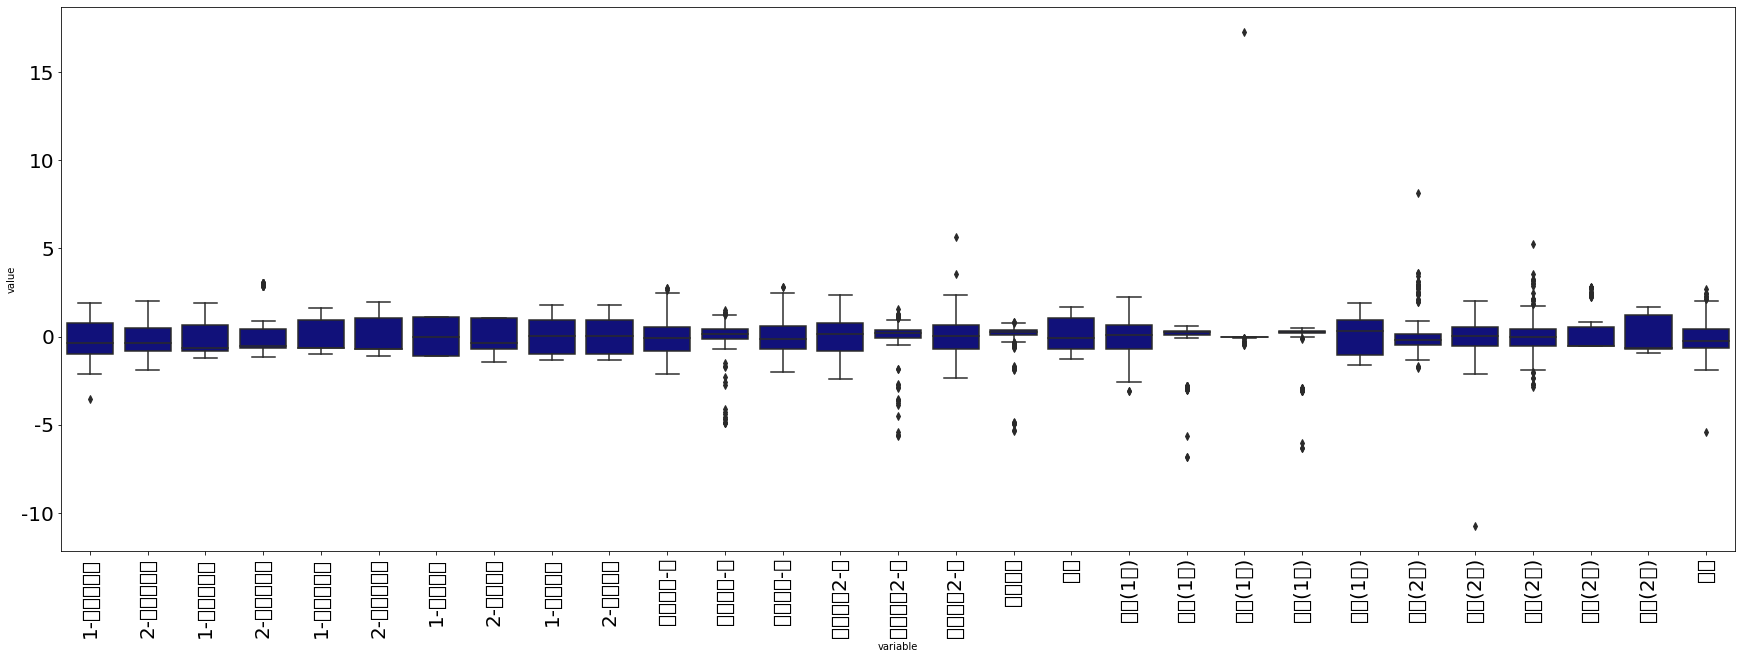

In [ ]:
plt.figure(figsize=(30,10))
sns.boxplot(x='variable', y='value', data=df_scaled_tmp_melt, color='DarkBlue')
plt.xticks(fontsize=20, rotation=90)
plt.yticks(fontsize=20)
plt.show

- Z-score(-2 이하, -2 이상)을 기준으로 봤을 때, outlier가 143개 존재함.. 
- Outlier를 제거하기보단 데이터를 최대한 살려야 함. 따라서 이상치에 영향을 적게 받는 Robust Normalization을 사용하는 것이 타당할듯

#### 3. 정규화: Robust Normalization

In [ ]:
from sklearn.preprocessing import RobustScaler

robustScaler = RobustScaler()
print(robustScaler.fit(df_scaled))
scaled_robust_np = robustScaler.transform(df_scaled)
df_scaled_robust = pd.DataFrame(data=scaled_robust_np, columns=df_scaled[numerical].columns)

RobustScaler()


In [ ]:
df_scaled_robust

,1-수소공급량,2-수소공급량,1-산소공급량,2-산소공급량,1-버너회전수,2-버너회전수,1-버너속도,2-버너속도,1-핀치횟수,2-핀치횟수,핀치두께-상,핀치두께-중,핀치두께-하,핀치두께2-상,핀치두께2-중,핀치두께2-하,전극간격,채널,전압(1차),전류(1차),역률(1차),전력(1차),온도(1차),전압(2차),전류(2차),역률(2차),전력(2차),온도(2차),강도
0,-0.66667,-0.50000,0.85000,0.66667,1.40000,1.00000,0.50000,0.80000,0.52479,0.52483,0.86667,0.11111,0.57143,0.83333,0.31579,0.58824,0.46535,-0.66667,-2.35744,1.46377,1.26087,0.40000,-0.90000,-0.12623,-0.93333,1.09091,-0.00028,0.93651,1.90476
1,-0.66667,-0.50000,0.85000,0.66667,1.40000,1.00000,0.50000,0.80000,0.52523,0.52528,0.93333,0.33333,0.71429,0.16667,0.00000,0.17647,0.11881,-0.33333,-2.35744,1.46377,1.26087,0.40000,-0.90000,1.22781,-1.66667,0.90909,0.00000,0.93651,2.46032
2,-0.66667,-0.50000,0.85000,0.66667,1.40000,1.00000,0.50000,0.80000,0.58553,0.58568,1.26667,0.66667,0.85714,0.16667,0.26316,-0.05882,-2.33663,-0.66667,-0.71694,0.75362,1.08696,0.80000,-0.90000,0.55621,-0.60000,0.81818,0.00005,1.04762,2.14286
3,-0.66667,-0.50000,0.85000,0.66667,1.40000,1.00000,0.50000,0.80000,0.58598,0.58613,1.33333,0.50000,0.85714,0.05556,0.26316,-0.05882,0.29703,-0.33333,-0.71694,0.75362,1.08696,0.80000,-0.90000,0.92505,-1.33333,0.50000,-0.00005,1.04762,2.38095
4,-0.66667,-0.50000,0.85000,0.66667,1.40000,1.00000,0.50000,0.80000,-0.62796,-0.62908,1.20000,0.88889,1.07143,0.66667,1.00000,0.64706,-0.33663,0.66667,-1.71074,0.72464,0.56522,-0.20000,-0.80000,-0.01479,-0.26667,0.81818,-0.00014,0.90476,2.26984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,-0.83333,-0.83333,-0.15000,-0.33333,0.00000,0.00000,-0.50000,0.00000,0.78026,0.78210,1.00000,-8.88889,1.21429,-0.77778,-8.47368,-0.47059,-0.90099,0.66667,0.24587,-0.73913,-0.17391,-0.62857,0.30000,-0.63807,0.13333,0.09091,-0.00028,0.00000,-0.68254
297,-0.83333,-0.83333,-0.15000,-0.33333,0.00000,0.00000,-0.50000,0.00000,0.78071,0.78255,0.86667,-9.33333,1.00000,-0.88889,-9.15789,-0.58824,-1.36634,1.00000,0.24587,-0.73913,-0.17391,-0.62857,0.30000,-0.14990,0.26667,0.18182,-0.00009,0.00000,-0.34921
298,-0.83333,-0.83333,-0.15000,-0.33333,0.00000,0.00000,-0.50000,0.00000,0.77892,0.78076,0.93333,-7.88889,1.14286,-0.72222,-8.84211,-0.35294,-0.85149,-0.33333,0.24587,-0.73913,-0.17391,-0.62857,0.30000,-0.07988,-1.00000,-0.63636,-0.00037,0.00000,-0.69841
299,-0.83333,-0.83333,-0.15000,-0.33333,0.00000,0.00000,-0.50000,0.00000,0.77490,0.77673,1.26667,-8.16667,1.42857,-0.88889,-8.57895,-0.58824,-0.52475,-0.33333,1.14463,-0.75362,0.00000,0.14286,0.40000,0.15976,-0.60000,-0.86364,-0.00018,0.00000,-0.60317


- Final Dataset 

In [ ]:
df_preprocessed = pd.concat([df[categorical], df_scaled_robust, df[y]], axis=1)

In [ ]:
df_preprocessed = df_preprocessed.iloc[:300, :]
df_preprocessed = df_preprocessed[df_preprocessed['현재 상태']!='Lamp Fail']
df_preprocessed['event'] = df_preprocessed['현재 상태'].apply(lambda x: int(0) if x=='Alive' else(int(1)))

In [ ]:
df_preprocessed

,Lot No.,Test No.,Lamp Ver. No.,현재 상태,1-수소공급량,2-수소공급량,1-산소공급량,2-산소공급량,1-버너회전수,2-버너회전수,1-버너속도,2-버너속도,1-핀치횟수,2-핀치횟수,핀치두께-상,핀치두께-중,핀치두께-하,핀치두께2-상,핀치두께2-중,핀치두께2-하,전극간격,채널,전압(1차),전류(1차),역률(1차),전력(1차),온도(1차),전압(2차),전류(2차),역률(2차),전력(2차),온도(2차),강도,y_cum_time,event
0,GV4KI7P051,21.00000,21.00000,Alive,-0.66667,-0.50000,0.85000,0.66667,1.40000,1.00000,0.50000,0.80000,0.52479,0.52483,0.86667,0.11111,0.57143,0.83333,0.31579,0.58824,0.46535,-0.66667,-2.35744,1.46377,1.26087,0.40000,-0.90000,-0.12623,-0.93333,1.09091,-0.00028,0.93651,1.90476,858.57000,0
1,GV4KI7P052,21.00000,21.00000,Alive,-0.66667,-0.50000,0.85000,0.66667,1.40000,1.00000,0.50000,0.80000,0.52523,0.52528,0.93333,0.33333,0.71429,0.16667,0.00000,0.17647,0.11881,-0.33333,-2.35744,1.46377,1.26087,0.40000,-0.90000,1.22781,-1.66667,0.90909,0.00000,0.93651,2.46032,858.57000,0
2,GV4KI7Q099,21.00000,21.00000,Alive,-0.66667,-0.50000,0.85000,0.66667,1.40000,1.00000,0.50000,0.80000,0.58553,0.58568,1.26667,0.66667,0.85714,0.16667,0.26316,-0.05882,-2.33663,-0.66667,-0.71694,0.75362,1.08696,0.80000,-0.90000,0.55621,-0.60000,0.81818,0.00005,1.04762,2.14286,858.57000,0
3,GV4KI7Q100,21.00000,21.00000,Alive,-0.66667,-0.50000,0.85000,0.66667,1.40000,1.00000,0.50000,0.80000,0.58598,0.58613,1.33333,0.50000,0.85714,0.05556,0.26316,-0.05882,0.29703,-0.33333,-0.71694,0.75362,1.08696,0.80000,-0.90000,0.92505,-1.33333,0.50000,-0.00005,1.04762,2.38095,858.57000,0
4,GV4KI8A058,21.00000,21.00000,Alive,-0.66667,-0.50000,0.85000,0.66667,1.40000,1.00000,0.50000,0.80000,-0.62796,-0.62908,1.20000,0.88889,1.07143,0.66667,1.00000,0.64706,-0.33663,0.66667,-1.71074,0.72464,0.56522,-0.20000,-0.80000,-0.01479,-0.26667,0.81818,-0.00014,0.90476,2.26984,838.28000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,GN4KL3V145,51.00000,69.00000,Gas leak,-0.83333,-0.83333,-0.15000,-0.33333,0.00000,0.00000,-0.50000,0.00000,0.77535,0.77718,1.06667,-8.38889,1.28571,-0.88889,-8.31579,-0.52941,-0.85149,0.00000,1.14463,-0.75362,0.00000,0.14286,0.40000,-0.04635,-0.40000,-1.27273,-0.00023,0.00000,0.39683,956.02000,1
296,GN4KL3V156,51.00000,69.00000,Gas leak,-0.83333,-0.83333,-0.15000,-0.33333,0.00000,0.00000,-0.50000,0.00000,0.78026,0.78210,1.00000,-8.88889,1.21429,-0.77778,-8.47368,-0.47059,-0.90099,0.66667,0.24587,-0.73913,-0.17391,-0.62857,0.30000,-0.63807,0.13333,0.09091,-0.00028,0.00000,-0.68254,946.02000,1
297,GN4KL3V157,51.00000,69.00000,Gas leak,-0.83333,-0.83333,-0.15000,-0.33333,0.00000,0.00000,-0.50000,0.00000,0.78071,0.78255,0.86667,-9.33333,1.00000,-0.88889,-9.15789,-0.58824,-1.36634,1.00000,0.24587,-0.73913,-0.17391,-0.62857,0.30000,-0.14990,0.26667,0.18182,-0.00009,0.00000,-0.34921,520.35000,1
298,GN4KL3V153,51.00000,69.00000,Gas leak,-0.83333,-0.83333,-0.15000,-0.33333,0.00000,0.00000,-0.50000,0.00000,0.77892,0.78076,0.93333,-7.88889,1.14286,-0.72222,-8.84211,-0.35294,-0.85149,-0.33333,0.24587,-0.73913,-0.17391,-0.62857,0.30000,-0.07988,-1.00000,-0.63636,-0.00037,0.00000,-0.69841,234.13000,1


In [ ]:
df_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 299
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Lot No.        300 non-null    object 
 1   Test No.       300 non-null    float64
 2   Lamp Ver. No.  300 non-null    float64
 3   현재 상태          300 non-null    object 
 4   1-수소공급량        300 non-null    float64
 5   2-수소공급량        300 non-null    float64
 6   1-산소공급량        300 non-null    float64
 7   2-산소공급량        300 non-null    float64
 8   1-버너회전수        300 non-null    float64
 9   2-버너회전수        300 non-null    float64
 10  1-버너속도         300 non-null    float64
 11  2-버너속도         300 non-null    float64
 12  1-핀치횟수         300 non-null    float64
 13  2-핀치횟수         300 non-null    float64
 14  핀치두께-상         300 non-null    float64
 15  핀치두께-중         300 non-null    float64
 16  핀치두께-하         300 non-null    float64
 17  핀치두께2-상        300 non-null    float64
 18  핀치두께2-중   

In [ ]:
df_preprocessed.to_excel('/content/gdrive/MyDrive/FactoryHack2022/Final/data/Final_Data.xlsx', index = False)